In [2]:
import requests
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from io import StringIO
# import telegram

from airflow.decorators import dag, task
from airflow.operators.python import get_current_context
from airflow.models import Variable

In [3]:
login = 'r-burehin-21'
year = 1994 + hash(f'{login}') % 23
print('year: ', year )

year:  1995


In [4]:
data_source = 'https://git.lab.karpov.courses/-/ide/project/lab/airflow/edit/master/-/dags/a.batalov/vgsales.csv'
# TOP_1M_DOMAINS_FILE = 'top-1m.csv'

In [5]:
default_args = {
    'owner': 'r-burehin-21',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 7, 7),
    'schedule_interval': '0 12 * * *'
}

In [6]:
CHAT_ID = 416830384
BOT_TOKEN = '1601804271:AAHVVVmPgjkyzM2q5v97dOtqCk9dC7OHJaw'

In [7]:
def send_message(context):
    date = context['ds']
    dag_id = context['dag'].dag_id
    message = f'Great!!! Huge success! Dag {dag_id} completed on {date}'
    if BOT_TOKEN != '':
        bot = telegram.Bot(token=BOT_TOKEN)
        bot.send_message(chat_id=CHAT_ID, text=message)
    else:
        pass

In [8]:
# data = requests.get(data_source, stream=True)
# data.content.decode('utf-8')

In [9]:
data = pd.read_csv('data/vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [10]:
EU_most_popular_genre = \
(data
 .groupby('Genre')
 .agg({'EU_Sales':'sum'})
 .sort_values('EU_Sales', ascending = False)
 .idxmax()
 .to_list()
)
EU_most_popular_genre

['Action']

In [11]:
(data
 .query("NA_Sales >= 1")
 .groupby('Platform')
 .agg({'Name': 'count'})
 .sort_values('Name', ascending = False)
 .idxmax()
 .to_list()
)

['PS2']

In [12]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [17]:
(data
 .groupby('Publisher')
 .agg({'JP_Sales': 'mean'})
 .sort_values('JP_Sales', ascending = False)
 .idxmax()
 .to_list()
)

['Enix Corporation']

In [19]:
@task(retries=4, retry_delay=timedelta(10))
def most_popular_platform_na(data):
    data = pd.read_csv(StringIO(data))
    highest_avg_sales_publisher = (data
                                 .groupby('Publisher')
                                 .agg({'JP_Sales': 'mean'})
                                 .sort_values('JP_Sales', ascending = False)
                                 .idxmax()
                                 .to_list()
                                )
    return {'highest_avg_sales_publisher': highest_avg_sales_publisher}

In [20]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [34]:
(data
 .groupby('Name')
 .agg({'EU_Sales': 'sum',
       'JP_Sales': 'sum', 
      })
 .query("EU_Sales > JP_Sales")
 .shape[0]
)

6036

In [ ]:
 @task(retries=4, retry_delay=timedelta(10))
def number_games_sold_better_in_eu_vs_jap(data):
    data = pd.read_csv(StringIO(data))
    number_games_sold_better_in_eu_vs_jap = (data
                                             .groupby('Name')
                                             .agg({'EU_Sales': 'sum',
                                                   'JP_Sales': 'sum', 
                                                  })
                                             .query("EU_Sales > JP_Sales")
                                             .shape[0]
                                            )
    return {'number_games_sold_better_in_eu_vs_jap': number_games_sold_better_in_eu_vs_jap}

In [ ]:
def most_popular_game(data):
    data = pd.read_csv(StringIO(data))
    game = (data
             .groupby('Name')
             .agg({'Global_Sales': 'sum'})
             .sort_values('Global_Sales', ascending = False)
             .idxmax()
             .to_list()[0]
            )
    return {'most_pop_game': game}

In [73]:
def most_popular_platform_na(data):
    data = pd.read_csv(StringIO(data))
    games_NA_sales_more_1mln = \
    (data
     .groupby('Name')
     .agg({'NA_Sales': 'sum'})
     .query("NA_Sales > 1")
     .index
     .to_list()
    )

    na_most_popular_platform = (
        data
        .query("Name.isin(@games_NA_sales_more_1mln)")
        .groupby('Platform')
        .agg({'Name': 'count'})
        .sort_values('Name', ascending = False)
        .idxmax()
        .to_list()
    )
    return {'na_most_popular_platform': na_most_popular_platform}

In [61]:
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [72]:
games_NA_sales_more_1mln = \
(data
 .groupby('Name')
 .agg({'NA_Sales': 'sum'})
 .query("NA_Sales > 1")
 .index
 .to_list()
)

na_most_popular_platform = (
    data
    .query("Name.isin(@games_NA_sales_more_1mln)")
    .groupby('Platform')
    .agg({'Name': 'count'})
    .sort_values('Name', ascending = False)
    .idxmax()
    .to_list()


)
na_most_popular_platform

# na_most_popular_platform

# (data
#  .assign(
#      NA_sales_more_1mln = np.where(lambda x: x.groupby('Name').agg({'NA_Sales': 'sum'})['NA_Sales'] >= 1, 1, 0)
#  )
#  .NA_sales_more_1mln.value_counts()
#  .query("NA_Sales >= 1")
#  .groupby('Platform')
#  .agg({'Name': 'count'})
#  .sort_values('Name', ascending = False)
#  .idxmax()
#  .to_list()
# )

['X360']

In [42]:
(data
 .groupby('Name')
 .agg({'Global_Sales': 'sum'})
 .sort_values('Global_Sales', ascending = False)
 .idxmax()
 .to_list()[0]
)

'Wii Sports'

In [21]:
data.shape

(16598, 11)

In [22]:
data.Name.nunique()

11493

In [24]:
data.Name.value_counts()

Need for Speed: Most Wanted       12
Ratatouille                        9
FIFA 14                            9
Madden NFL 07                      9
LEGO Marvel Super Heroes           9
                                  ..
Super Swing Golf Season 2          1
Iron & Blood                       1
Miami Law                          1
Guitar Rock Tour                   1
Yu Yu Hakusho: Dark Tournament     1
Name: Name, Length: 11493, dtype: int64

In [27]:
data.query("Name == 'LEGO Marvel Super Heroes'")

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
690,692,LEGO Marvel Super Heroes,X360,2013.0,Action,Warner Bros. Interactive Entertainment,1.24,0.85,0.00,0.21,2.30
846,848,LEGO Marvel Super Heroes,PS3,2013.0,Action,Warner Bros. Interactive Entertainment,0.77,0.85,0.01,0.37,2.00
1193,1195,LEGO Marvel Super Heroes,PS4,2013.0,Action,Warner Bros. Interactive Entertainment,0.59,0.75,0.01,0.21,1.56
2007,2009,LEGO Marvel Super Heroes,XOne,2013.0,Action,Warner Bros. Interactive Entertainment,0.61,0.34,0.00,0.09,1.04
2344,2346,LEGO Marvel Super Heroes,3DS,2013.0,Action,Warner Bros. Interactive Entertainment,0.42,0.36,0.04,0.07,0.89
2774,2776,LEGO Marvel Super Heroes,WiiU,2013.0,Action,Warner Bros. Interactive Entertainment,0.31,0.35,0.02,0.06,0.74
3080,3082,LEGO Marvel Super Heroes,PSV,2013.0,Action,Warner Bros. Interactive Entertainment,0.15,0.35,0.00,0.16,0.66
4056,4058,LEGO Marvel Super Heroes,DS,2013.0,Action,Warner Bros. Interactive Entertainment,0.28,0.17,0.00,0.04,0.49
8095,8097,LEGO Marvel Super Heroes,PC,2013.0,Action,Warner Bros. Interactive Entertainment,0.04,0.12,0.00,0.02,0.18


In [ ]:
@task(retries=4, retry_delay=timedelta(10))
def most_popular_genre_eu(data):
    data = pd.read_csv(StringIO(data))
    na_most_popular_platform = (data
                                 .query("NA_Sales >= 1")
                                 .groupby('Platform')
                                 .agg({'Name': 'count'})
                                 .sort_values('Name', ascending = False)
                                 .idxmax()
                                 .to_list()
                                )
    return {'na_most_popular_platform': na_most_popular_platform}

In [25]:
@task(retries=4, retry_delay=timedelta(10))
def most_popular_genre_eu(data):
    data = pd.read_csv(StringIO(data))
    eu_most_popular_genre = (data
                               .groupby('Genre')
                               .agg({'EU_Sales':'sum'})
                               .sort_values('EU_Sales', ascending = False)
                               .idxmax()
                               .to_list()
                              )
    return {'eu_most_popular_genre': eu_most_popular_genre}

In [47]:
data.to_csv('data/data_downloaded.csv',index=False)

In [ ]:
pd.read_csv(StringIO(top_data), names=['rank', 'domain'])

In [52]:
data = data.query("Year == @year")

In [51]:
pd.read_csv(StringIO(data))

TypeError: initial_value must be str or None, not DataFrame

In [61]:
data.sort_values('Global_Sales', ascending = False).Name.head(1).to_list()[0]

'Kinect Adventures!'

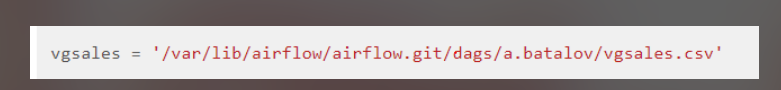

In [ ]:
# data_source = '/var/lib/airflow/airflow.git/dags/a.batalov/vgsales.csv'

In [10]:
@dag(default_args=default_args, catchup=False, tags= ["bur_train"])
def games_br_v1():
    @task(retries=3)
    def get_data():
        data_source = '/var/lib/airflow/airflow.git/dags/a.batalov/vgsales.csv'
        data = pd.read_csv(data_source)
        login = 'r-burehin-21'
        year = 1994 + hash(f'{login}') % 23
        
        data = data.query("Year == @year")
        
        return data.to_csv(index=False)

    @task(retries=4, retry_delay=timedelta(10))
    def most_popular_game(data):
        data = pd.read_csv(StringIO(data))
        game = data.sort_values('Global_Sales', ascending = False).Name.head(1).to_list()[0]
        return {'most_pop_game': game}

#     @task()
#     def get_stat_ru(top_data_ru):
#         ru_df = pd.read_csv(StringIO(top_data_ru))
#         ru_avg = int(ru_df['rank'].aggregate(np.mean))
#         ru_median = int(ru_df['rank'].aggregate(np.median))
#         return {'ru_avg': ru_avg, 'ru_median': ru_median}

#     @task()
#     def get_table_com(top_data):
#         top_data_df = pd.read_csv(StringIO(top_data), names=['rank', 'domain'])
#         top_data_com = top_data_df[top_data_df['domain'].str.endswith('.com')]
#         return top_data_com.to_csv(index=False)

#     @task()
#     def get_stat_com(top_data_com):
#         com_df = pd.read_csv(StringIO(top_data_com))
#         com_avg = int(com_df['rank'].aggregate(np.mean))
#         com_median = int(com_df['rank'].aggregate(np.median))
#         return {'com_avg': com_avg, 'com_median': com_median}

    @task(on_success_callback=send_message)
    def print_data(stat):

        context = get_current_context()
        date = context['ds']

        game = stat['most_pop_game']
#         com_avg, com_median = com_stat['com_avg'], com_stat['com_median']

        print(f'''Data from .RU for {date}
                  Most popular game: {game}
                  ''')


    data = get_data()
    stat = most_popular_game(data)
    

    print_data(stat)

games_br_v1 = games_br_v1()